# 0 Imports and helper functions

https://gallery.azure.ai/Experiment/837e2095ce784f1ba5ac623a60232027

In [1]:
import sklearn
import pandas as pd
from sklearn import tree
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from sklearn.metrics import roc_curve, auc
import json

%matplotlib inline

In [2]:
def one_hot(df,features):
    all_column_names = []
    for feature in features:
        names = list(df[feature].unique())
        for i, name in enumerate(names):
            column_name = str(feature)+'_'+str(i)
            df[column_name] = df[feature].apply(lambda x: 1 if x==name else 0)
            all_column_names.append(column_name)
    df.drop(columns=features,inplace=True)
    #return all_column_names

In [3]:
def explore_cat(df,feature):
    print("unique values:")
    print(df[feature].unique())
    print("number of unique values")
    print(df[feature].unique().shape)

In [4]:
def count_M(df,feature,verbose=True):
    r=df[df[feature] == "M"][feature].count()
    if verbose:
        print(r)
    return r

In [5]:
def remove_M(df):
    original_length = len(df)
    for c in df.columns.tolist():
        if df.dtypes[c] == 'object':
            m = count_M(df,c,verbose=False)
            print("Removed {0} in column {1}".format(m,c))
            df = df[df[c] != "M"]
            try: 
                df[c] = df[c].astype(np.float64)
            except:
                pass
    n_removed = original_length - len(df)
    print("")
    print("Removed {0} of {1}".format(n_removed,original_length))
    return df

In [6]:
def hhmm_to_h(hhmm, mode):
    #mode = 'up' or 'down'
    if not (mode == 'up' or mode == 'down'):
        raise Exception("mode must be up or down")
    if len(str(hhmm)) <= 2:
        if mode == 'up':
            h = 1
        else:
            h = 0
    else:
        h = int(str(hhmm)[:-2])
        if mode == 'up':
            h += 1
    return h

# 1 Loading the data

In [9]:
delays = pd.read_csv("FlightDelaysData.csv",header=0)
weather = pd.read_csv("WeatherDataset.csv",header=0)

C:\Users\gbaeke\AppData\Local\Programs\Python\Python35\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (7,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
delays.head()

,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,ArrDel15,Cancelled
0,2013,4,19,5,DL,11433,13303,837,-3.0,0.0,1138,1.0,0.0,0.0
1,2013,4,19,5,DL,14869,12478,1705,0.0,0.0,2336,-8.0,0.0,0.0
2,2013,4,19,5,DL,14057,14869,600,-4.0,0.0,851,-15.0,0.0,0.0
3,2013,4,19,5,DL,15016,11433,1630,28.0,1.0,1903,24.0,1.0,0.0
4,2013,4,19,5,DL,11193,12892,1615,-6.0,0.0,1805,-11.0,0.0,0.0


In [11]:
weather.head()

,AirportID,Year,Month,Day,Time,TimeZone,SkyCondition,Visibility,WeatherType,DryBulbFarenheit,...,WindSpeed,WindDirection,ValueForWindCharacter,StationPressure,PressureTendency,PressureChange,SeaLevelPressure,RecordType,HourlyPrecip,Altimeter
0,14843,2013,4,1,56,-4,FEW018 SCT044 BKN070,10.00,-RA,76,...,13,080,,30.06,,,30.06,AA,T,30.07
1,14843,2013,4,1,156,-4,FEW037 SCT070,10.00,,76,...,10,090,,30.05,6,017,30.05,AA,,30.06
2,14843,2013,4,1,256,-4,FEW037 SCT070,10.00,,76,...,9,100,,30.03,,,30.03,AA,,30.04
3,14843,2013,4,1,356,-4,FEW025 SCT070,10.00,,76,...,9,100,,30.02,,,30.03,AA,,30.03
4,14843,2013,4,1,456,-4,FEW025,10.00,,76,...,7,110,,30.03,5,004,30.04,AA,,30.04


In [12]:
weather['Time'].max()

2359

# 2 Cleaning weather data

## 2.1 Dropping columns with lots of empty strings

In [13]:
weather["ValueForWindCharacter"].unique()

array([' ', '21', '23', '24', '25', '26', '28', '18', '22', '20', '32',
       '29', '17', '16', '30', '31', '37', '40', '38', '39', '36', '34',
       '43', '33', '49', '59', '47', '44', '41', '46', '56', '53', '48',
       '45', '54', '51', '55', '52', '70', '71', '68', '14', '61', '60',
       '67', '58', '69', '66', '89', '64', '74'], dtype=object)

In [14]:
perc = weather[weather["ValueForWindCharacter"] == ' ']["ValueForWindCharacter"].count()/len(weather)
print(perc)

0.8781868364344823


In [15]:
weather["PressureTendency"].unique()

array([' ', '6', '5', '3', '1', '8', '0', '2', '7', '4'], dtype=object)

In [16]:
perc = weather[weather["PressureTendency"] == ' ']["PressureTendency"].count()/len(weather)
print(perc)

0.9606608349978845


In [17]:
weather["WeatherType"].unique()

array(['-RA', ' ', '+RA BR', 'RA BR', '-RA BR', 'RA', '+RA', 'TSRA',
       '-TSRA BR', '-TSRA', '-DZ BR', 'BCFG', '+TSRA FG', 'BR', 'FG',
       'BR BCFG', 'VCFG', 'FU BR', '+TSRA BR', 'TSRA BR', 'MIFG', 'TS',
       '+TSRA', '+RA FG', '-TSRA SQ', '+FC -RA', '+FC', 'VCTS RA BR',
       'VCTS', 'VCTS -RA', 'HZ', '-DZ', 'MIFG BR', 'DZ BR', '+TS RAGS BR',
       '+TS RAGR BR', '+TS GSRA FG', '+TS GSRA BR', 'TS BR', '-PLRA',
       '-RAPL', '+TSRA BR SQ', 'BCFG BR', '+DZ FG', '+DZ', 'SQ', '-DZ FG',
       '+TSRA SQ', 'FG BR', 'TS RAGS', 'TS RAGR', '-DZ HZ', 'TS FZRA',
       'TS -FZRA', '-FZRA', '-FZRA BR', 'FZRA BR', '-SN BR', '-FZRAPL BR',
       'TS HZ', '-SN', '-RA FG', '-RASN', 'RA BR FU', '-TSRA BR SQ',
       '-RAGS', 'UP BR', 'RAPL BR', '-TSSN', 'SN FZFG', '-PLUP',
       '-PL SNRA', '-FZRASN', '-FZRASN BR', 'SN FG', '+SN FG', '-TSSN BR',
       '-DZSN BR', '-SNDZ BR', 'FZRASN BR', 'PLRA BR', '-PLRA BR',
       '-RASN BR', '-PL BR', 'PL BR', '-SN FG', '-SNPL BR', '-SNRA',
       '

In [18]:
perc = weather[weather["WeatherType"] == ' ']["WeatherType"].count()/len(weather)
print(perc)

0.8648614076690708


In [19]:
weather["PressureChange"].unique()

array([' ', '017', '004', '020', '008', '023', '011', '005', '013', '002',
       '018', '000', '022', '010', '016', '014', '003', '009', '026',
       '006', '015', '001', '019', '012', '007', '021', '025', '051',
       '036', '030', '024', '028', '027', '047', '043', '031', '035',
       '056', '032', '054', '038', '029', '046', '039', '033', '044',
       '034', '037', '042', '040', '070', '045', '041', '060', '049',
       '050', '071', '076', '048', '065', '055', '062', '067', '059',
       '063', '058', '080'], dtype=object)

In [20]:
perc = weather[weather["PressureChange"] == ' ']["PressureChange"].count()/len(weather)
print(perc)

0.9606608349978845


In [21]:
weather["HourlyPrecip"].unique()

array(['  T', ' ', '0.01', '0.02', '0.03', '0.04', '0.12', '0.21', '0.05',
       '0.10', '0.08', '0.13', '0.06', '1.05', '0.17', '0.09', '0.15',
       '0.19', '0.18', '0.32', '0.25', '0.31', '0.74', '0.28', '0.61',
       '0.36', '0.11', '0.14', '0.16', '0.07', '0.38', '1.25', '0.52',
       '0.40', '0.48', '0.65', '0.81', '0.67', '0.84', '0.20', '0.30',
       '0.92', '0.47', '0.77', '0.94', '0.83', '0.26', '0.23', '0.73',
       '0.60', '0.93', '0.44', '0.46', '1.22', '0.54', '0.29', '0.33',
       '0.43', '0.34', '0.88', '0.39', '0.59', '1.00', '0.53', '0.27',
       '3.03', '1.89', '0.24', '1.03', '0.49', '0.22', '0.71', '0.35',
       '0.37', '0.69', '0.66', '0.56', '0.58', '0.41', '1.02', '1.50',
       '0.57', '0.79', '0.64', '0.80', '0.55', '0.97', '0.75', '1.47',
       '0.42', '0.68', '1.23', '0.45', '0.51', '2.70', '1.04', '0.72',
       '2.29', '1.68', '1.75', '0.90', '0.63', '2.00', '1.79', '1.20',
       '0.85', '1.36', '0.87', '1.83', '1.39', '4.00', '1.24', '1.53',
  

In [22]:
perc = weather[weather["HourlyPrecip"] == ' ']["HourlyPrecip"].count()/len(weather)
print(perc)

0.9212503320902499


**Dropping the columns identified above..**

In [23]:
weather.drop(columns=["ValueForWindCharacter","PressureTendency","WeatherType","PressureChange","HourlyPrecip"],inplace=True)
weather.head()

,AirportID,Year,Month,Day,Time,TimeZone,SkyCondition,Visibility,DryBulbFarenheit,DryBulbCelsius,...,WetBulbCelsius,DewPointFarenheit,DewPointCelsius,RelativeHumidity,WindSpeed,WindDirection,StationPressure,SeaLevelPressure,RecordType,Altimeter
0,14843,2013,4,1,56,-4,FEW018 SCT044 BKN070,10.00,76,24.4,...,23.3,73,22.8,90,13,080,30.06,30.06,AA,30.07
1,14843,2013,4,1,156,-4,FEW037 SCT070,10.00,76,24.4,...,22.5,71,21.7,85,10,090,30.05,30.05,AA,30.06
2,14843,2013,4,1,256,-4,FEW037 SCT070,10.00,76,24.4,...,22.5,71,21.7,85,9,100,30.03,30.03,AA,30.04
3,14843,2013,4,1,356,-4,FEW025 SCT070,10.00,76,24.4,...,22.2,70,21.1,82,9,100,30.02,30.03,AA,30.03
4,14843,2013,4,1,456,-4,FEW025,10.00,76,24.4,...,22.2,70,21.1,82,7,110,30.03,30.04,AA,30.04


## 2.2 Exploring some other columns and converting to one-hot

**Don't one-hot-encode airportID yet, we first need to join on this**

In [24]:
#explore_cat(weather,"AirportID")

In [25]:
explore_cat(weather,"SkyCondition")

unique values:
['FEW018 SCT044 BKN070' 'FEW037 SCT070' 'FEW025 SCT070' ...
 'SCT008 BKN025 OVC075' 'BKN012 BKN035 OVC090' 'BKN012 BKN045 OVC095']
number of unique values
(82826,)


**Not sure how to deal with this one above... maybe remove it?**

In [26]:
explore_cat(weather,"Visibility")

unique values:
['10.00' ' 8.00' ' 9.00' ' 1.00' ' 2.00' ' 4.00' ' 6.00' ' 7.00' ' 3.00'
 ' 5.00' ' 0.50' ' 0.75' ' 1.50' ' 1.49' ' 2.50' ' 1.75' ' 1.25' ' 0.25'
 ' 0.12' ' 0.00' 'M' ' 9.94' '30.00' ' 1.74' 10.0 7.0 1.75 3.0 9.0 6.0 5.0
 8.0 4.0 2.0 2.5 0.5 1.5 1.25 1.0 0.75 0.25 0.12 0.0 35.0 ' 10.00' 13.0]
number of unique values
(46,)


**Visibility has some "M" values. More on this below...**

In [27]:
weather.dtypes

AirportID             int64
Year                  int64
Month                 int64
Day                   int64
Time                  int64
TimeZone              int64
SkyCondition         object
Visibility           object
DryBulbFarenheit     object
DryBulbCelsius       object
WetBulbFarenheit     object
WetBulbCelsius       object
DewPointFarenheit    object
DewPointCelsius      object
RelativeHumidity     object
WindSpeed            object
WindDirection        object
StationPressure      object
SeaLevelPressure     object
RecordType           object
Altimeter            object
dtype: object

In [28]:
explore_cat(weather,"RecordType")

unique values:
['AA' 'SP' 'SY-MT' 'AUTO']
number of unique values
(4,)


**Converting AirportID to one-hot encoding. Leaving Visibility as float.** The function one_hot does this "inplace".  
**Dropping the column SkyCondition (for now?). Aslo dropping RecordType, does not seem meaningful.**

In [29]:
weather.drop(columns=["SkyCondition","RecordType"],inplace=True)
#one_hot(weather,["AirportID"])


In [30]:
print(weather.dtypes)
weather.head()

AirportID             int64
Year                  int64
Month                 int64
Day                   int64
Time                  int64
TimeZone              int64
Visibility           object
DryBulbFarenheit     object
DryBulbCelsius       object
WetBulbFarenheit     object
WetBulbCelsius       object
DewPointFarenheit    object
DewPointCelsius      object
RelativeHumidity     object
WindSpeed            object
WindDirection        object
StationPressure      object
SeaLevelPressure     object
Altimeter            object
dtype: object


,AirportID,Year,Month,Day,Time,TimeZone,Visibility,DryBulbFarenheit,DryBulbCelsius,WetBulbFarenheit,WetBulbCelsius,DewPointFarenheit,DewPointCelsius,RelativeHumidity,WindSpeed,WindDirection,StationPressure,SeaLevelPressure,Altimeter
0,14843,2013,4,1,56,-4,10.00,76,24.4,74,23.3,73,22.8,90,13,080,30.06,30.06,30.07
1,14843,2013,4,1,156,-4,10.00,76,24.4,73,22.5,71,21.7,85,10,090,30.05,30.05,30.06
2,14843,2013,4,1,256,-4,10.00,76,24.4,73,22.5,71,21.7,85,9,100,30.03,30.03,30.04
3,14843,2013,4,1,356,-4,10.00,76,24.4,72,22.2,70,21.1,82,9,100,30.02,30.03,30.03
4,14843,2013,4,1,456,-4,10.00,76,24.4,72,22.2,70,21.1,82,7,110,30.03,30.04,30.04


## 2.3 Removing the M's and casting to numerical. Winddirection to categorical one-hot

A lot of numerical values are parsed as an object (see dtypes list above) because they contain some weird "M" values.
Let's count the M in some of these columns

In [31]:
explore_cat(weather,"Visibility") #Here, also note inconsistent data type: ints + strings with leading whitespace

unique values:
['10.00' ' 8.00' ' 9.00' ' 1.00' ' 2.00' ' 4.00' ' 6.00' ' 7.00' ' 3.00'
 ' 5.00' ' 0.50' ' 0.75' ' 1.50' ' 1.49' ' 2.50' ' 1.75' ' 1.25' ' 0.25'
 ' 0.12' ' 0.00' 'M' ' 9.94' '30.00' ' 1.74' 10.0 7.0 1.75 3.0 9.0 6.0 5.0
 8.0 4.0 2.0 2.5 0.5 1.5 1.25 1.0 0.75 0.25 0.12 0.0 35.0 ' 10.00' 13.0]
number of unique values
(46,)


In [32]:
explore_cat(weather,"DryBulbFarenheit")

unique values:
['76' '77' '79' '82' '83' '84' '86' '85' '81' '80' '78' '75' '88' '89'
 '87' '90' '74' '72' '73' '65' '64' '62' '63' '67' '70' '69' '66' '68'
 '60' '71' '61' '58' '57' '55' '56' '59' '91' '92' '54' '53' '52' '51'
 '50' '49' 'M' '48' '47' '46' '45' '44' '43' '42' ' -26' '40' '39' '37'
 '41' '38' '36' '35' '33' '32' '31' '34' '30' '29' '28' '27' '26' '25'
 '24' '23' '22' '21' '20' '19' '93' '94' '95' '96' '98' '97' '99' ' 100'
 ' 102' ' 101' '18' '17' '15' '14' '13' '12' '11' '16' '8' '10' ' 103'
 ' 104' ' 105' ' 106' ' 108' ' 107' ' 109' ' 110' ' 112' ' 113' ' 111'
 ' 114' ' 115' ' 116' ' 118' ' 117']
number of unique values
(112,)


In [33]:
explore_cat(weather,'Altimeter')

unique values:
['30.07' '30.06' '30.04' '30.03' '30.05' '30.08' '30.10' '30.12' '30.13'
 '30.09' '30.02' '30.01' '30.00' '29.99' '29.97' '29.98' '29.96' '29.95'
 '29.94' '29.93' '30.11' '29.88' '29.90' '29.89' '29.92' '29.91' '29.86'
 '29.83' '29.84' '29.87' '29.85' '30.15' '30.16' '30.14' '30.17' '30.18'
 '30.19' '30.20' '30.21' '30.22' '30.23' '30.25' '30.26' '30.24' '29.78'
 '29.81' '29.77' '29.76' '29.75' '29.74' '29.73' '29.72' '29.71' '29.67'
 '29.66' '29.70' '29.69' 'M' '29.68' '29.79' '29.82' '29.80' '30.29'
 '30.33' '30.32' '30.31' '30.27' '30.30' '30.28' '29.65' '29.62' '29.59'
 '29.58' '29.57' '29.63' '29.64' '30.35' '30.36' '30.39' '30.43' '30.45'
 '30.47' '30.49' '30.48' '30.46' '30.44' '30.42' '30.41' '30.38' '30.34'
 '30.40' '30.37' '29.61' '30.52' '30.54' '30.55' '30.53' '30.56' '30.51'
 '30.57' '30.59' '30.60' '30.62' '30.63' '30.61' '30.58' '30.50' '29.60'
 '29.56' '29.55' '29.54' '29.52' '29.51' '29.50' '29.49' '30.64' '30.66'
 '30.65' '30.68' '30.69' '30.70' '30.71'

In [34]:
weather2 = remove_M(weather)

Removed 108 in column Visibility


C:\Users\gbaeke\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Removed 221 in column DryBulbFarenheit
Removed 0 in column DryBulbCelsius
Removed 1202 in column WetBulbFarenheit
Removed 0 in column WetBulbCelsius
Removed 0 in column DewPointFarenheit
Removed 0 in column DewPointCelsius
Removed 0 in column RelativeHumidity
Removed 41 in column WindSpeed
Removed 29 in column WindDirection
Removed 0 in column StationPressure
Removed 72070 in column SeaLevelPressure
Removed 2 in column Altimeter

Removed 73673 of 406516


**Above function did not remove rows inplace. A lot of 'M' present in SeaLevelPressure Let's remove this column, then move on
to removing all rows with an M**  

In [35]:
weather.drop(columns=["SeaLevelPressure"],inplace=True)

In [36]:
weather = remove_M(weather)
weather.dtypes

Removed 108 in column Visibility


C:\Users\gbaeke\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Removed 221 in column DryBulbFarenheit
Removed 0 in column DryBulbCelsius
Removed 1202 in column WetBulbFarenheit
Removed 0 in column WetBulbCelsius
Removed 0 in column DewPointFarenheit
Removed 0 in column DewPointCelsius
Removed 0 in column RelativeHumidity
Removed 41 in column WindSpeed
Removed 29 in column WindDirection
Removed 0 in column StationPressure
Removed 2 in column Altimeter

Removed 1603 of 406516


AirportID              int64
Year                   int64
Month                  int64
Day                    int64
Time                   int64
TimeZone               int64
Visibility           float64
DryBulbFarenheit     float64
DryBulbCelsius       float64
WetBulbFarenheit     float64
WetBulbCelsius       float64
DewPointFarenheit    float64
DewPointCelsius      float64
RelativeHumidity     float64
WindSpeed             object
WindDirection         object
StationPressure      float64
Altimeter            float64
dtype: object

**apparently, some columns still have weird strings as value. Also, windspeed contains inconsistent data types (int, strings, even strings with leading whitespace...**

In [37]:
explore_cat(weather,"WindSpeed")

unique values:
['13' '10' ' 9' ' 7' '14' '16' '17' '20' '18' '15' '11' ' 5' ' 6' ' 3'
 ' 8' ' 0' '21' '22' '23' '24' '26' '25' '30' '29' '32' '34' '40' '37'
 '28' '31' '44' '39' '33' '38' '36' '43' '41' '45' '53' '  ' '46' '51'
 '47' '62' 0 6 3 5 7 8 10 9 11 13 15 14 16 18 20 17 21 22 23 24 26 25 31
 30 33 28 29 36]
number of unique values
(72,)


In [38]:
weather[weather["WindSpeed"] == '  ']["WindSpeed"].count()


3

In [39]:
weather[weather["WindSpeed"] == 0]["WindSpeed"].count()

3233

**Winddirection has some value 'VR' that appears an amount of times that is not negligible. Let's pack this value in a categorical one-hot encoded one where VR remains represented. All can be simply casted to int, even if there is whitespace**

In [40]:
weather = weather[weather["WindSpeed"] != '  ']
weather["WindSpeed"] = weather["WindSpeed"].astype(np.int64)

In [41]:
explore_cat(weather2,"WindDirection")

unique values:
['080' '090' '100' '110' '070' '000' '130' '150' '160' '120' '170' '180'
 '060' '230' '200' '050' 'VR ' '140' '210' '290' '190' '030' '040' '020'
 '010' '360' '220' '260' '250' '270' '280' '300' '320' '340' '350' '310'
 '240' '330' '239']
number of unique values
(39,)


In [42]:
weather[weather["WindDirection"] == 'VR ']["WindSpeed"].count()

11274

In [43]:
direction_categories = [0,40,80,120,160,200,240,280,320,360]
def check_cat(x,cat):
    try: #try-catch block because VR cannot be compared to int.
        if int(x)>cat-20 and int(x)<=cat+20:
            return 1
        else:
            return 0
    except:
        return 0
    
weather["dir_VR"] = weather["WindDirection"].apply(lambda x: 1 if x == 'VR ' else 0)
for cat in direction_categories:
    weather["dir_{0}".format(cat)] = weather["WindDirection"].apply(lambda x: check_cat(x,cat))
weather.drop(columns=["WindDirection"],inplace=True)

In [44]:
weather.head()

,AirportID,Year,Month,Day,Time,TimeZone,Visibility,DryBulbFarenheit,DryBulbCelsius,WetBulbFarenheit,...,dir_0,dir_40,dir_80,dir_120,dir_160,dir_200,dir_240,dir_280,dir_320,dir_360
0,14843,2013,4,1,56,-4,10.0,76.0,24.4,74.0,...,0,0,1,0,0,0,0,0,0,0
1,14843,2013,4,1,156,-4,10.0,76.0,24.4,73.0,...,0,0,1,0,0,0,0,0,0,0
2,14843,2013,4,1,256,-4,10.0,76.0,24.4,73.0,...,0,0,1,0,0,0,0,0,0,0
3,14843,2013,4,1,356,-4,10.0,76.0,24.4,72.0,...,0,0,1,0,0,0,0,0,0,0
4,14843,2013,4,1,456,-4,10.0,76.0,24.4,72.0,...,0,0,0,1,0,0,0,0,0,0


In [45]:
weather.dtypes

AirportID              int64
Year                   int64
Month                  int64
Day                    int64
Time                   int64
TimeZone               int64
Visibility           float64
DryBulbFarenheit     float64
DryBulbCelsius       float64
WetBulbFarenheit     float64
WetBulbCelsius       float64
DewPointFarenheit    float64
DewPointCelsius      float64
RelativeHumidity     float64
WindSpeed              int64
StationPressure      float64
Altimeter            float64
dir_VR                 int64
dir_0                  int64
dir_40                 int64
dir_80                 int64
dir_120                int64
dir_160                int64
dir_200                int64
dir_240                int64
dir_280                int64
dir_320                int64
dir_360                int64
dtype: object

## 2.4 Handling time

We round time to nearest hour. Time of weather data is rounded UP and time of flight data is rounded DOWN, to make sure that weather conditions after the flight departure/arrival are not a deciding factor. We create a datetime string "YYYY-M-D-H". 

**timezone?** According to docs: "the weather data is reported in local time". We will leave this in local time and use this to join it to the delay data, where arrival and departure times are also in local times.

In [46]:
explore_cat(weather,'Year')

unique values:
[2013]
number of unique values
(1,)


In [47]:
explore_cat(weather,'Month')

unique values:
[ 4  5  6  7  8  9 10]
number of unique values
(7,)


In [48]:
explore_cat(weather,'Day')

unique values:
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
number of unique values
(31,)


In [49]:
weather.dtypes

AirportID              int64
Year                   int64
Month                  int64
Day                    int64
Time                   int64
TimeZone               int64
Visibility           float64
DryBulbFarenheit     float64
DryBulbCelsius       float64
WetBulbFarenheit     float64
WetBulbCelsius       float64
DewPointFarenheit    float64
DewPointCelsius      float64
RelativeHumidity     float64
WindSpeed              int64
StationPressure      float64
Altimeter            float64
dir_VR                 int64
dir_0                  int64
dir_40                 int64
dir_80                 int64
dir_120                int64
dir_160                int64
dir_200                int64
dir_240                int64
dir_280                int64
dir_320                int64
dir_360                int64
dtype: object

In [50]:
explore_cat(weather,'Time')

unique values:
[  56  156  256 ... 2118 1601 2257]
number of unique values
(1440,)


In [51]:
weather["hour"] = weather["Time"].apply(lambda x: hhmm_to_h(x,mode='up'))

In [52]:
weather["datetime"] = weather["Year"].astype(str)+'-'+weather["Month"].astype(str)+'-'+weather["Day"].astype(str)+'-'+weather["hour"].astype(str)

In [53]:
weather.dtypes

AirportID              int64
Year                   int64
Month                  int64
Day                    int64
Time                   int64
TimeZone               int64
Visibility           float64
DryBulbFarenheit     float64
DryBulbCelsius       float64
WetBulbFarenheit     float64
WetBulbCelsius       float64
DewPointFarenheit    float64
DewPointCelsius      float64
RelativeHumidity     float64
WindSpeed              int64
StationPressure      float64
Altimeter            float64
dir_VR                 int64
dir_0                  int64
dir_40                 int64
dir_80                 int64
dir_120                int64
dir_160                int64
dir_200                int64
dir_240                int64
dir_280                int64
dir_320                int64
dir_360                int64
hour                   int64
datetime              object
dtype: object

In [54]:
weather.head()

,AirportID,Year,Month,Day,Time,TimeZone,Visibility,DryBulbFarenheit,DryBulbCelsius,WetBulbFarenheit,...,dir_80,dir_120,dir_160,dir_200,dir_240,dir_280,dir_320,dir_360,hour,datetime
0,14843,2013,4,1,56,-4,10.0,76.0,24.4,74.0,...,1,0,0,0,0,0,0,0,1,2013-4-1-1
1,14843,2013,4,1,156,-4,10.0,76.0,24.4,73.0,...,1,0,0,0,0,0,0,0,2,2013-4-1-2
2,14843,2013,4,1,256,-4,10.0,76.0,24.4,73.0,...,1,0,0,0,0,0,0,0,3,2013-4-1-3
3,14843,2013,4,1,356,-4,10.0,76.0,24.4,72.0,...,1,0,0,0,0,0,0,0,4,2013-4-1-4
4,14843,2013,4,1,456,-4,10.0,76.0,24.4,72.0,...,0,1,0,0,0,0,0,0,5,2013-4-1-5


# 3 Cleaning delay data

## 3.1 One-hot encode Carrier, drop a column, handle time

In [55]:
delays.head()

,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,ArrDel15,Cancelled
0,2013,4,19,5,DL,11433,13303,837,-3.0,0.0,1138,1.0,0.0,0.0
1,2013,4,19,5,DL,14869,12478,1705,0.0,0.0,2336,-8.0,0.0,0.0
2,2013,4,19,5,DL,14057,14869,600,-4.0,0.0,851,-15.0,0.0,0.0
3,2013,4,19,5,DL,15016,11433,1630,28.0,1.0,1903,24.0,1.0,0.0
4,2013,4,19,5,DL,11193,12892,1615,-6.0,0.0,1805,-11.0,0.0,0.0


In [56]:
explore_cat(delays,"Carrier")

unique values:
['DL' 'AA' 'EV' 'B6' 'F9' 'FL' 'HA' 'MQ' '9E' 'AS' 'US' 'UA' 'VX' 'WN'
 'YV' 'OO']
number of unique values
(16,)


In [57]:
delays.drop(columns = "DayOfWeek",inplace=True)

In [58]:
delays["Dep_hour"] = delays["CRSDepTime"].apply(lambda x: hhmm_to_h(x,mode="down"))
delays["Arr_hour"] = delays["CRSArrTime"].apply(lambda x: hhmm_to_h(x,mode="down"))

In [59]:
one_hot(delays,["Carrier"])

In [60]:
delays.head()

,Year,Month,DayofMonth,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,...,Carrier_6,Carrier_7,Carrier_8,Carrier_9,Carrier_10,Carrier_11,Carrier_12,Carrier_13,Carrier_14,Carrier_15
0,2013,4,19,11433,13303,837,-3.0,0.0,1138,1.0,...,0,0,0,0,0,0,0,0,0,0
1,2013,4,19,14869,12478,1705,0.0,0.0,2336,-8.0,...,0,0,0,0,0,0,0,0,0,0
2,2013,4,19,14057,14869,600,-4.0,0.0,851,-15.0,...,0,0,0,0,0,0,0,0,0,0
3,2013,4,19,15016,11433,1630,28.0,1.0,1903,24.0,...,0,0,0,0,0,0,0,0,0,0
4,2013,4,19,11193,12892,1615,-6.0,0.0,1805,-11.0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
delays.columns

Index(['Year', 'Month', 'DayofMonth', 'OriginAirportID', 'DestAirportID',
       'CRSDepTime', 'DepDelay', 'DepDel15', 'CRSArrTime', 'ArrDelay',
       'ArrDel15', 'Cancelled', 'Dep_hour', 'Arr_hour', 'Carrier_0',
       'Carrier_1', 'Carrier_2', 'Carrier_3', 'Carrier_4', 'Carrier_5',
       'Carrier_6', 'Carrier_7', 'Carrier_8', 'Carrier_9', 'Carrier_10',
       'Carrier_11', 'Carrier_12', 'Carrier_13', 'Carrier_14', 'Carrier_15'],
      dtype='object')

In [62]:
delays.dtypes

Year                 int64
Month                int64
DayofMonth           int64
OriginAirportID      int64
DestAirportID        int64
CRSDepTime           int64
DepDelay           float64
DepDel15           float64
CRSArrTime           int64
ArrDelay           float64
ArrDel15           float64
Cancelled          float64
Dep_hour             int64
Arr_hour             int64
Carrier_0            int64
Carrier_1            int64
Carrier_2            int64
Carrier_3            int64
Carrier_4            int64
Carrier_5            int64
Carrier_6            int64
Carrier_7            int64
Carrier_8            int64
Carrier_9            int64
Carrier_10           int64
Carrier_11           int64
Carrier_12           int64
Carrier_13           int64
Carrier_14           int64
Carrier_15           int64
dtype: object

**Let's assume date information is date of the arrival in local time of origin airport. Also assume arrival and departure time are in local time zone of respective airport. If departure time is later than arrival time, then the arrival is on the next day, so this must be taken into account when constructing Arr_datetime and Dep_datetime (add one day to Dep_datetime). Introducting the helper column "dep_after_arr" (1 or 0). The code below may set Arrival day on non-existing day (e.g. august 
32), but let's ignore these cases and let them disappear in the join.**

In [63]:
type(delays["CRSArrTime"]<delays["CRSDepTime"])

pandas.core.series.Series

In [64]:
delays["dep_after_arr"] = (delays["CRSArrTime"]<delays["CRSDepTime"])

In [65]:
delays["Dep_datetime"] = delays["Year"].astype(str)+'-'+delays["Month"].astype(str)+'-'+delays["DayofMonth"].astype(str)+'-'+delays["Dep_hour"].astype(str)

In [66]:
delays["DayofMonth_arr"] = delays["DayofMonth"]+delays["dep_after_arr"]

In [67]:
weather["Year"].unique()

array([2013], dtype=int64)

In [68]:
delays["Arr_datetime"] = delays["Year"].astype(str)+'-'+delays["Month"].astype(str)+'-'+delays["DayofMonth_arr"].astype(str)+'-'+delays["Arr_hour"].astype(str)

In [69]:
weather.columns

Index(['AirportID', 'Year', 'Month', 'Day', 'Time', 'TimeZone', 'Visibility',
       'DryBulbFarenheit', 'DryBulbCelsius', 'WetBulbFarenheit',
       'WetBulbCelsius', 'DewPointFarenheit', 'DewPointCelsius',
       'RelativeHumidity', 'WindSpeed', 'StationPressure', 'Altimeter',
       'dir_VR', 'dir_0', 'dir_40', 'dir_80', 'dir_120', 'dir_160', 'dir_200',
       'dir_240', 'dir_280', 'dir_320', 'dir_360', 'hour', 'datetime'],
      dtype='object')

In [70]:
len(weather[weather["AirportID"]==14843])

5333

In [71]:
explore_cat(weather[weather["AirportID"]==14843],"datetime")

unique values:
['2013-4-1-1' '2013-4-1-2' '2013-4-1-3' ... '2013-10-31-22'
 '2013-10-31-23' '2013-10-31-24']
number of unique values
(5089,)


## 3.2 Join with OriginAirport weather

**Apparently, in the weather data sometimes for the same airport two measurements are available in the same hour (i.e. same datetime). We need to drop these duplicates (let's not care which one we keep exactly) so that we have unique airport-datetime combinations. Then, we can index on these columns (double index). Then we can join the dataframes. **

In [72]:
weather.drop_duplicates(subset=["AirportID","datetime"],keep="last",inplace=True)

In [73]:
len(weather)

338035

In [74]:
weather.set_index(keys=["AirportID","datetime"],inplace=True)

In [75]:
delays.columns

Index(['Year', 'Month', 'DayofMonth', 'OriginAirportID', 'DestAirportID',
       'CRSDepTime', 'DepDelay', 'DepDel15', 'CRSArrTime', 'ArrDelay',
       'ArrDel15', 'Cancelled', 'Dep_hour', 'Arr_hour', 'Carrier_0',
       'Carrier_1', 'Carrier_2', 'Carrier_3', 'Carrier_4', 'Carrier_5',
       'Carrier_6', 'Carrier_7', 'Carrier_8', 'Carrier_9', 'Carrier_10',
       'Carrier_11', 'Carrier_12', 'Carrier_13', 'Carrier_14', 'Carrier_15',
       'dep_after_arr', 'Dep_datetime', 'DayofMonth_arr', 'Arr_datetime'],
      dtype='object')

In [76]:
delays.rename(columns={"OriginAirportID":"AirportID"},inplace=True)

In [77]:
delays.rename(columns={"Dep_datetime":"datetime"},inplace=True)

In [78]:
delays=delays.join(weather,on=["AirportID","datetime"],rsuffix="_depweather")

In [79]:
delays.drop(columns=["Year_depweather","Month_depweather","Day"],inplace=True)

In [80]:
delays.columns

Index(['Year', 'Month', 'DayofMonth', 'AirportID', 'DestAirportID',
       'CRSDepTime', 'DepDelay', 'DepDel15', 'CRSArrTime', 'ArrDelay',
       'ArrDel15', 'Cancelled', 'Dep_hour', 'Arr_hour', 'Carrier_0',
       'Carrier_1', 'Carrier_2', 'Carrier_3', 'Carrier_4', 'Carrier_5',
       'Carrier_6', 'Carrier_7', 'Carrier_8', 'Carrier_9', 'Carrier_10',
       'Carrier_11', 'Carrier_12', 'Carrier_13', 'Carrier_14', 'Carrier_15',
       'dep_after_arr', 'datetime', 'DayofMonth_arr', 'Arr_datetime', 'Time',
       'TimeZone', 'Visibility', 'DryBulbFarenheit', 'DryBulbCelsius',
       'WetBulbFarenheit', 'WetBulbCelsius', 'DewPointFarenheit',
       'DewPointCelsius', 'RelativeHumidity', 'WindSpeed', 'StationPressure',
       'Altimeter', 'dir_VR', 'dir_0', 'dir_40', 'dir_80', 'dir_120',
       'dir_160', 'dir_200', 'dir_240', 'dir_280', 'dir_320', 'dir_360',
       'hour'],
      dtype='object')

In [81]:
weather_columns = weather.columns[5:] #excluding year,month,day,time,timezone
weather_columns

Index(['Visibility', 'DryBulbFarenheit', 'DryBulbCelsius', 'WetBulbFarenheit',
       'WetBulbCelsius', 'DewPointFarenheit', 'DewPointCelsius',
       'RelativeHumidity', 'WindSpeed', 'StationPressure', 'Altimeter',
       'dir_VR', 'dir_0', 'dir_40', 'dir_80', 'dir_120', 'dir_160', 'dir_200',
       'dir_240', 'dir_280', 'dir_320', 'dir_360', 'hour'],
      dtype='object')

In [82]:
delays_columns_old = delays.columns

In [83]:
delays_columns_new = []
for column in delays_columns_old:
    if column in weather_columns:
        delays_columns_new.append(column+"_originAirport")
    else:
        delays_columns_new.append(column)
        
delays.columns = delays_columns_new
delays.rename(columns={"AirportID":"OriginAirportID"})
delays.columns

Index(['Year', 'Month', 'DayofMonth', 'AirportID', 'DestAirportID',
       'CRSDepTime', 'DepDelay', 'DepDel15', 'CRSArrTime', 'ArrDelay',
       'ArrDel15', 'Cancelled', 'Dep_hour', 'Arr_hour', 'Carrier_0',
       'Carrier_1', 'Carrier_2', 'Carrier_3', 'Carrier_4', 'Carrier_5',
       'Carrier_6', 'Carrier_7', 'Carrier_8', 'Carrier_9', 'Carrier_10',
       'Carrier_11', 'Carrier_12', 'Carrier_13', 'Carrier_14', 'Carrier_15',
       'dep_after_arr', 'datetime', 'DayofMonth_arr', 'Arr_datetime', 'Time',
       'TimeZone', 'Visibility_originAirport',
       'DryBulbFarenheit_originAirport', 'DryBulbCelsius_originAirport',
       'WetBulbFarenheit_originAirport', 'WetBulbCelsius_originAirport',
       'DewPointFarenheit_originAirport', 'DewPointCelsius_originAirport',
       'RelativeHumidity_originAirport', 'WindSpeed_originAirport',
       'StationPressure_originAirport', 'Altimeter_originAirport',
       'dir_VR_originAirport', 'dir_0_originAirport', 'dir_40_originAirport',
       'dir

## 3.3 Join with DestinationAirport weather

In [84]:
delays.drop(columns=["dep_after_arr"],inplace=True)

In [85]:
delays.rename(columns={"AirportID":"OriginAirportID","DestAirportID":"AirportID"},inplace=True)

In [86]:
delays.rename(columns={"datetime":"Dep_datetime","Arr_datetime":"datetime"},inplace=True)

In [87]:
delays=delays.join(weather,on=["AirportID","datetime"],rsuffix="_arrweather")

In [88]:
delays.columns

Index(['Year', 'Month', 'DayofMonth', 'OriginAirportID', 'AirportID',
       'CRSDepTime', 'DepDelay', 'DepDel15', 'CRSArrTime', 'ArrDelay',
       'ArrDel15', 'Cancelled', 'Dep_hour', 'Arr_hour', 'Carrier_0',
       'Carrier_1', 'Carrier_2', 'Carrier_3', 'Carrier_4', 'Carrier_5',
       'Carrier_6', 'Carrier_7', 'Carrier_8', 'Carrier_9', 'Carrier_10',
       'Carrier_11', 'Carrier_12', 'Carrier_13', 'Carrier_14', 'Carrier_15',
       'Dep_datetime', 'DayofMonth_arr', 'datetime', 'Time', 'TimeZone',
       'Visibility_originAirport', 'DryBulbFarenheit_originAirport',
       'DryBulbCelsius_originAirport', 'WetBulbFarenheit_originAirport',
       'WetBulbCelsius_originAirport', 'DewPointFarenheit_originAirport',
       'DewPointCelsius_originAirport', 'RelativeHumidity_originAirport',
       'WindSpeed_originAirport', 'StationPressure_originAirport',
       'Altimeter_originAirport', 'dir_VR_originAirport',
       'dir_0_originAirport', 'dir_40_originAirport', 'dir_80_originAirport',
  

In [89]:
delays.drop(columns=["Year_arrweather","Month_arrweather","Day"],inplace=True)

In [90]:
delays.columns

Index(['Year', 'Month', 'DayofMonth', 'OriginAirportID', 'AirportID',
       'CRSDepTime', 'DepDelay', 'DepDel15', 'CRSArrTime', 'ArrDelay',
       'ArrDel15', 'Cancelled', 'Dep_hour', 'Arr_hour', 'Carrier_0',
       'Carrier_1', 'Carrier_2', 'Carrier_3', 'Carrier_4', 'Carrier_5',
       'Carrier_6', 'Carrier_7', 'Carrier_8', 'Carrier_9', 'Carrier_10',
       'Carrier_11', 'Carrier_12', 'Carrier_13', 'Carrier_14', 'Carrier_15',
       'Dep_datetime', 'DayofMonth_arr', 'datetime', 'Time', 'TimeZone',
       'Visibility_originAirport', 'DryBulbFarenheit_originAirport',
       'DryBulbCelsius_originAirport', 'WetBulbFarenheit_originAirport',
       'WetBulbCelsius_originAirport', 'DewPointFarenheit_originAirport',
       'DewPointCelsius_originAirport', 'RelativeHumidity_originAirport',
       'WindSpeed_originAirport', 'StationPressure_originAirport',
       'Altimeter_originAirport', 'dir_VR_originAirport',
       'dir_0_originAirport', 'dir_40_originAirport', 'dir_80_originAirport',
  

In [91]:
weather_columns = weather.columns[5:] #excluding year,month,day,time,timezone
weather_columns

Index(['Visibility', 'DryBulbFarenheit', 'DryBulbCelsius', 'WetBulbFarenheit',
       'WetBulbCelsius', 'DewPointFarenheit', 'DewPointCelsius',
       'RelativeHumidity', 'WindSpeed', 'StationPressure', 'Altimeter',
       'dir_VR', 'dir_0', 'dir_40', 'dir_80', 'dir_120', 'dir_160', 'dir_200',
       'dir_240', 'dir_280', 'dir_320', 'dir_360', 'hour'],
      dtype='object')

In [92]:
delays_columns_old = delays.columns

In [93]:
delays_columns_new = []
for column in delays_columns_old:
    if column in weather_columns:
        delays_columns_new.append(column+"_destAirport")
    else:
        delays_columns_new.append(column)
        
delays.columns = delays_columns_new
delays.rename(columns={"AirportID":"DestAirportID"},inplace=True)
delays.columns

Index(['Year', 'Month', 'DayofMonth', 'OriginAirportID', 'DestAirportID',
       'CRSDepTime', 'DepDelay', 'DepDel15', 'CRSArrTime', 'ArrDelay',
       'ArrDel15', 'Cancelled', 'Dep_hour', 'Arr_hour', 'Carrier_0',
       'Carrier_1', 'Carrier_2', 'Carrier_3', 'Carrier_4', 'Carrier_5',
       'Carrier_6', 'Carrier_7', 'Carrier_8', 'Carrier_9', 'Carrier_10',
       'Carrier_11', 'Carrier_12', 'Carrier_13', 'Carrier_14', 'Carrier_15',
       'Dep_datetime', 'DayofMonth_arr', 'datetime', 'Time', 'TimeZone',
       'Visibility_originAirport', 'DryBulbFarenheit_originAirport',
       'DryBulbCelsius_originAirport', 'WetBulbFarenheit_originAirport',
       'WetBulbCelsius_originAirport', 'DewPointFarenheit_originAirport',
       'DewPointCelsius_originAirport', 'RelativeHumidity_originAirport',
       'WindSpeed_originAirport', 'StationPressure_originAirport',
       'Altimeter_originAirport', 'dir_VR_originAirport',
       'dir_0_originAirport', 'dir_40_originAirport', 'dir_80_originAirport'

In [94]:
delays.head()

,Year,Month,DayofMonth,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,...,dir_40_destAirport,dir_80_destAirport,dir_120_destAirport,dir_160_destAirport,dir_200_destAirport,dir_240_destAirport,dir_280_destAirport,dir_320_destAirport,dir_360_destAirport,hour_destAirport
0,2013,4,19,11433,13303,837,-3.0,0.0,1138,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0
1,2013,4,19,14869,12478,1705,0.0,0.0,2336,-8.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,23.0
2,2013,4,19,14057,14869,600,-4.0,0.0,851,-15.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
3,2013,4,19,15016,11433,1630,28.0,1.0,1903,24.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,19.0
4,2013,4,19,11193,12892,1615,-6.0,0.0,1805,-11.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,18.0


**Some columns were only needed for joining the data but will not be used as features. Let's assume that the exact flight times don't matter, only the weather conditions at those times. For now the only target variable is ArrDelay, we exclude other related columns**

In [95]:
delays_clean=delays.drop(columns=["Year","Month","DayofMonth","CRSDepTime","CRSArrTime","Dep_hour","Arr_hour","Dep_datetime",
                                 "DayofMonth_arr","datetime","Time","TimeZone","hour_originAirport","Time_arrweather",
                                 "TimeZone_arrweather","hour_destAirport","DepDelay","DepDel15","ArrDelay","Cancelled"])
print(delays_clean.dtypes.unique())
delays_clean.columns
one_hot(delays_clean,["OriginAirportID","DestAirportID"])

[dtype('int64') dtype('float64')]


In [96]:
delays_clean.dropna(inplace=True)

In [97]:
Y = delays_clean["ArrDel15"].astype(np.float64).values
X = delays_clean.drop(columns=["ArrDel15"]).astype(np.float64).values

In [98]:
np.save("X.npy",X)
np.save("Y.npy",Y)

In [14]:
X = np.load("X.npy")
Y = np.load("Y.npy")

In [15]:
X_train, X_devtest, Y_train, Y_devtest = train_test_split(X,Y,random_state=0,test_size = 0.10)
X_dev, X_test, Y_dev, Y_test = train_test_split(X_devtest,Y_devtest,random_state=0,test_size = 0.50)

# 4 Decision tree classifier

## 4.1 Building the model

In [104]:
def evaluate_clf(clf,X,Y,plot=True):
    Y_pred = clf.predict_proba(X)[:,1]
    fpr,tpr,thresholds = roc_curve(Y,Y_pred)
    if plot:
        plt.plot(fpr,tpr)
    AUC = auc(fpr,tpr)
    return AUC

In [101]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
print(Y_dev.shape)
print(Y_dev.shape)

(1924238, 200)
(106903, 200)
(1924238,)
(106903,)
(106902,)
(106902,)


In [150]:
clf = tree.DecisionTreeClassifier(random_state=0, min_samples_split = 1000,max_depth = 20)

In [134]:
start = time.time()
clf.fit(X_train, Y_train)
end = time.time()

seconds = end-start
print("Fitting took {0} seconds".format(seconds))

Fitting took 224.89454913139343 seconds


In [135]:
X_train.shape

(1924238, 200)

In [136]:
p = clf.predict_proba(X_test)
p

array([[0.91938376, 0.08061624],
       [0.82355954, 0.17644046],
       [0.81050677, 0.18949323],
       ...,
       [0.84695215, 0.15304785],
       [0.84695215, 0.15304785],
       [0.66781361, 0.33218639]])

In [137]:
print(len(p))
print(np.sum(p==0)+np.sum(p==1))
print()

213805
0



In [112]:
len(clf.feature_importances_)

200

In [117]:
help(clf.tree_)

Help on Tree object:

class Tree(builtins.object)
 |  Array-based representation of a binary decision tree.
 |  
 |  The binary tree is represented as a number of parallel arrays. The i-th
 |  element of each array holds information about the node `i`. Node 0 is the
 |  tree's root. You can find a detailed description of all arrays in
 |  `_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split
 |  nodes, resp. In this case the values of nodes of the other type are
 |  arbitrary!
 |  
 |  Attributes
 |  ----------
 |  node_count : int
 |      The number of nodes (internal nodes + leaves) in the tree.
 |  
 |  capacity : int
 |      The current capacity (i.e., size) of the arrays, which is at least as
 |      great as `node_count`.
 |  
 |  max_depth : int
 |      The maximal depth of the tree.
 |  
 |  children_left : array of int, shape [node_count]
 |      children_left[i] holds the node id of the left child of node i.
 |      For leaves, children_left[i] == TREE_LE

In [127]:
clf.tree_.max_depth

20

In [141]:
p.shape

(213805, 2)

In [128]:
clf.tree_.node_count

17735

0.6448286481318811

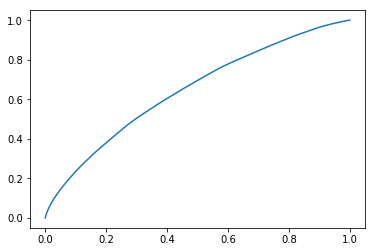

In [147]:
evaluate_clf(clf,X_train,Y_train)

In [152]:
a=evaluate_clf(clf,X_test,Y_test)

NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

## 4.2 Hyperparameter search

In [102]:
split_list = [2,500,1000,2000]
depth_list = [10,20,30,40]

2 / 10
2 / 20
2 / 30
2 / 40
500 / 10
500 / 20
500 / 30
500 / 40
1000 / 10
1000 / 20
1000 / 30
1000 / 40
2000 / 10
2000 / 20
2000 / 30
2000 / 40
{'run_6': {'auc_train': 0.7303856667732778, 'split': 500, 'depth': 30, 'auc_dev': 0.6748519463265837}, 'run_0': {'auc_train': 0.6527034329248941, 'split': 2, 'depth': 10, 'auc_dev': 0.6465847349996299}, 'run_3': {'auc_train': 0.9901079484713191, 'split': 2, 'depth': 40, 'auc_dev': 0.5793248062261067}, 'run_4': {'auc_train': 0.6514636524788621, 'split': 500, 'depth': 10, 'auc_dev': 0.646608779731869}, 'run_7': {'auc_train': 0.7391849252866118, 'split': 500, 'depth': 40, 'auc_dev': 0.6735938002712927}, 'run_12': {'auc_train': 0.6493058581458026, 'split': 2000, 'depth': 10, 'auc_dev': 0.6454488154198862}, 'run_11': {'auc_train': 0.712907419989401, 'split': 1000, 'depth': 40, 'auc_dev': 0.6739786028844735}, 'run_9': {'auc_train': 0.6937047403903195, 'split': 1000, 'depth': 20, 'auc_dev': 0.6719229531165309}, 'run_15': {'auc_train': 0.69278397533991

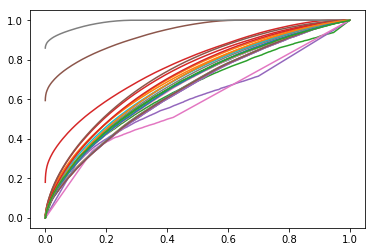

In [109]:
result_dict = {}
i = 0
optimal_results = {"split":split_list[0],"depth":depth_list[0],"auc_dev":0}
clf_best = None
for s in split_list:
    for d in depth_list:
        print(str(s)+" / "+str(d))
        clf = tree.DecisionTreeClassifier(random_state=0, min_samples_split = s,max_depth = d)
        clf.fit(X_train, Y_train)
        auc_dev = evaluate_clf(clf,X_dev,Y_dev,plot=False)
        if auc_dev > optimal_results["auc_dev"]:
            optimal_results["split"] = s
            optimal_results["depth"] = d
            optimal_results["auc_dev"] = auc_dev
            clf_best = clf
        auc_train = evaluate_clf(clf,X_train,Y_train,plot=False)
        result_dict["run_"+str(i)] = {"split":s,"depth":d,"auc_train":auc_train,"auc_dev":auc_dev}
        i += 1
        
print(result_dict)

optimal_results["auc_test"] = evaluate_clf(clf_best,X_test,Y_test,plot=False)



with open('result_decisiontreeCLF.txt','a') as f:
    f.write(json.dumps(result_dict,sort_keys=True,indent=4))
    f.write("Best results:")
    f.write(json.dumps(optimal_results,sort_keys=True,indent=4))
    

# 5 Dense neural network

In [13]:
from keras import layers
from keras.layers import Input, Add, Dense, Activation, Dropout, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
import tensorflow as tf

Using TensorFlow backend.


In [11]:
def delayNNmodel(input_shape,hidden_units = [100,100],dropout_rate = 0.1):
    
    #input layer
    X_input = Input(input_shape)
    
    #first hidden layer
    X = Dense(hidden_units[0])(X_input)
    X = Activation('relu')(X)
    X = Dropout(dropout_rate,seed=0)(X)
    
    #next hidden layer(s)
    if len(hidden_units)>2:
        for n in hidden_units[1:]:
            X = Dense(n)(X)
            X = Activation('relu')(X)
            X = Dropout(dropout_rate,seed=0)(X)
    elif len(hidden_units) == 2:
        X = Dense(hidden_units[1])(X)
        X = Activation('relu')(X)
        X = Dropout(dropout_rate,seed=0)(X)
        
    #output layer
    X = Dense(1)(X)
    X = Activation('sigmoid')(X)
    
    model = Model(inputs = X_input, outputs = X, name = 'delayBinaryClassifierNN')
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [10]:
def evaluate_NN(model,X,Y,plot=False):
    Y_pred = model.predict(X)
    fpr,tpr,thresholds = roc_curve(Y,Y_pred)
    if plot:
        plt.plot(fpr,tpr)
    AUC = auc(fpr,tpr)
    return AUC

In [8]:
def fit_and_plot(model,X_train,Y_train,X_test,Y_test,epochs = 10,verbose=False,evaluate_offset = 0):
    auc_test = []
    auc_train = []
    for i in range(epochs):
        print(i)
        model.fit(X_train,Y_train,epochs=1,batch_size=128,verbose=0)
        if i >= evaluate_offset:
            auc_test_ = evaluate_NN(model,X_test,Y_test,plot=False)
            auc_test.append(auc_test_)
            auc_train_ = evaluate_NN(model,X_train,Y_train,plot=False)
            auc_train.append(auc_train_)
            if verbose:
                print("Epoch {2}. Test auc: {0}, Train auc: {1}".format(auc_test_,auc_train_,i))
    plt.figure()
    plt.plot(np.arange(len(auc_test)),auc_test,'r',np.arange(len(auc_train)),auc_train,'b')
    plt.show()
    return model

**never name the output of this function 'auc' since it collides with the name of the function auc, imported above**

auc_ = evaluate_NN(model,X_test,Y_test,plot=False)
print(auc_)

**Output is always 0, see cell below. Let's try to balance to dataset first, since it is skewed towards output 0**

In [139]:
pred=model.predict(X_train)
np.sum(pred>0.00001)

0

In [141]:
np.sum(Y_train==1)/Y_train.shape[0]

0.21225804708149407

In [142]:
np.sum(Y_train==0)/Y_train.shape[0]

0.7877419529185059

In [16]:
#turn this into a robust reusable function!

index_0 = (Y_train==0)
index_1 = (Y_train==1)
print(np.sum(index_0))
print(np.sum(index_1))
amt_1 = np.sum(index_1)
Y_train_0 = Y_train[index_0]
Y_train_1 = Y_train[index_1]
X_train_0 = X_train[index_0]
X_train_1= X_train[index_1]

np.random.seed(0)
selection_0 = np.random.randint(0,Y_train_0.shape[0],amt_1)

Y_train_0_selected = Y_train_0[selection_0]
X_train_0_selected = X_train_0[selection_0]

X_train_balanced = np.append(X_train_0_selected,X_train_1,axis=0)
Y_train_balanced = np.append(Y_train_0_selected,Y_train_1,axis=0)

print(X_train_balanced.shape)
print(np.expand_dims(Y_train_balanced,axis=1).shape)

XY = np.append(X_train_balanced,np.expand_dims(Y_train_balanced,axis=1),axis=1)
np.random.shuffle(XY)
X_train_balanced = XY[:,0:-1]
Y_train_balanced = XY[:,-1]

print(X_train_balanced.shape)
print(Y_train_balanced.shape)

1515803
408435
(816870, 200)
(816870, 1)
(816870, 200)
(816870,)


Epoch 1/1
816870/816870 [==============================] - 11s 14us/step - loss: 0.7072 - acc: 0.5774
Epoch 0. Test auc: 0.6502808914769697, Train auc: 0.6470881794865477
Epoch 1/1
816870/816870 [==============================] - 11s 13us/step - loss: 0.6635 - acc: 0.5989
Epoch 1. Test auc: 0.6546190910458762, Train auc: 0.6532343825949037
Epoch 1/1
816870/816870 [==============================] - 11s 13us/step - loss: 0.6590 - acc: 0.6052
Epoch 2. Test auc: 0.6574285401007209, Train auc: 0.655030532673549


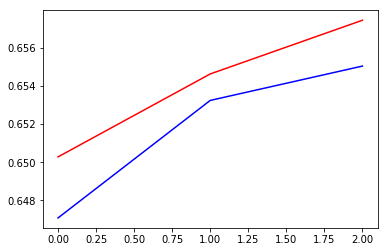

In [31]:
input_shape = [X_train.shape[1]]
model = delayNNmodel(input_shape,dropout_rate=0)
fit_and_plot(model,X_train_balanced,Y_train_balanced,X_test,Y_test,verbose=True,epochs=3)

In [164]:
auc_ = evaluate_NN(model,X_test,Y_test,plot=False)
print(auc_)

0.6561154672356233


units: [128, 128], dropout: 0
0
1
2
3
4
5


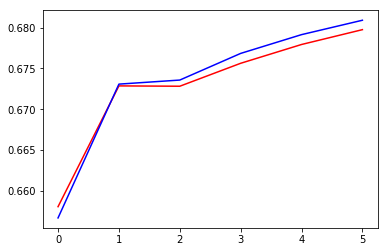

units: [128, 128], dropout: 0.05
0
1
2
3
4
5


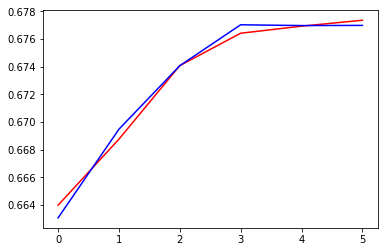

units: [128, 128], dropout: 0.1
0
1
2
3
4
5


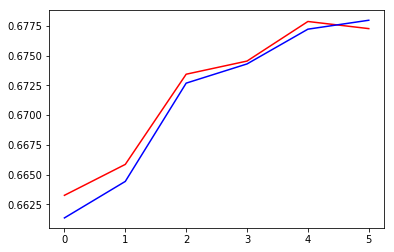

units: [128, 128], dropout: 0.2
0
1
2
3
4
5


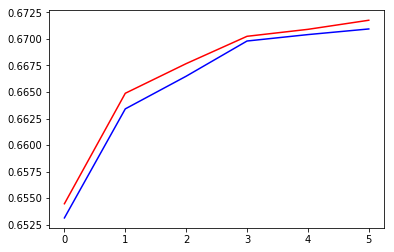

units: [128, 128, 128], dropout: 0
0
1
2
3
4
5


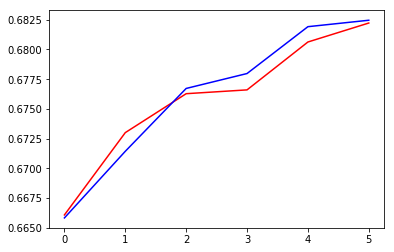

units: [128, 128, 128], dropout: 0.05
0
1
2
3
4
5


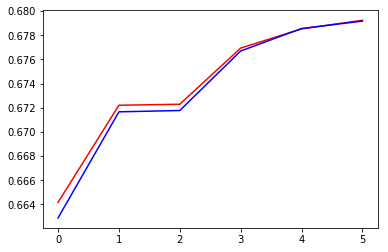

units: [128, 128, 128], dropout: 0.1
0
1
2
3
4
5


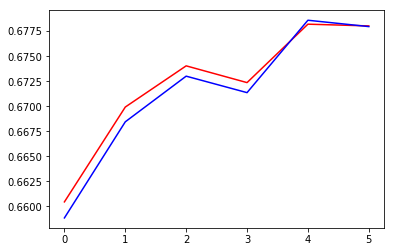

units: [128, 128, 128], dropout: 0.2
0
1
2
3
4
5


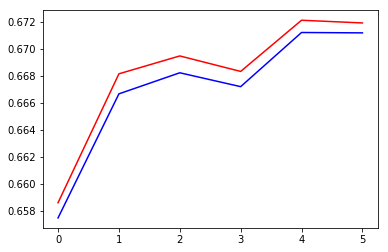

units: [256, 256, 128], dropout: 0
0
1
2
3
4
5


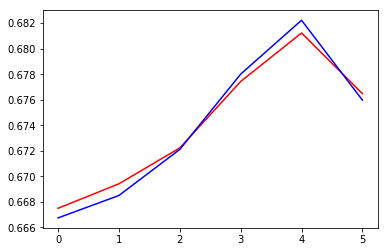

units: [256, 256, 128], dropout: 0.05
0
1
2
3
4
5


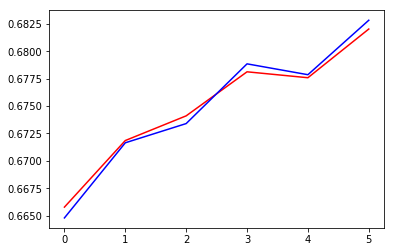

units: [256, 256, 128], dropout: 0.1
0
1
2
3
4
5


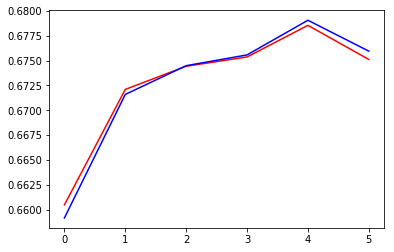

units: [256, 256, 128], dropout: 0.2
0
1
2
3
4
5


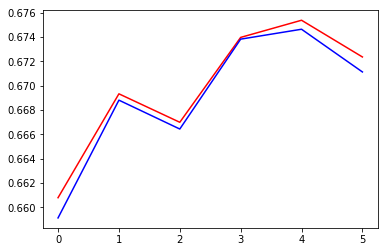

In [43]:
units = [[128,128],[128,128,128],[256,256,128]]
dropout_rates = [0,0.05,0.1,0.2]
for u in units:
    for dropout_rate in dropout_rates:
        model = delayNNmodel(input_shape, hidden_units = u, dropout_rate = dropout_rate)
        print("units: {0}, dropout: {1}".format(u,dropout_rate))
        fit_and_plot(model,X_train_balanced,Y_train_balanced,X_test,Y_test,verbose=False,epochs=6)

**doing extra epochs for those who seem promising**

units: [128, 128], dropout: 0
0
1
2
3
4
5
6
7
8
9


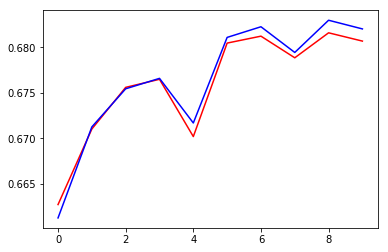

units: [128, 128, 128], dropout: 0
0
1
2
3
4
5
6
7
8
9


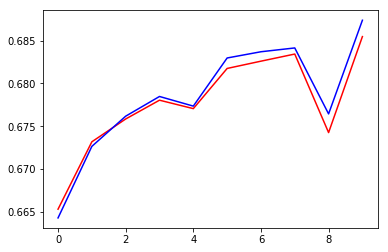

units: [128, 128, 128], dropout: 0.05
0
1
2
3
4
5
6
7
8
9


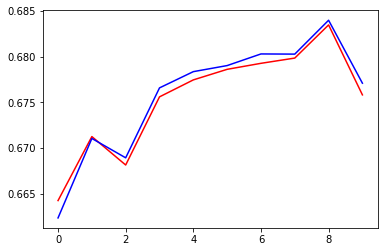

units: [256, 256, 128], dropout: 0.05
0
1
2
3
4
5
6
7
8
9


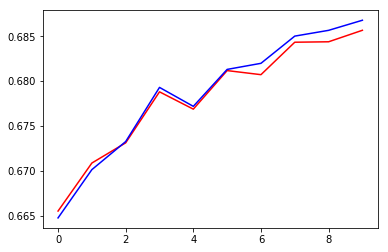

In [44]:
units = [[128,128],[128,128,128],[128,128,128],[256,256,128]]
dropout_rates = [0,0,0.05,0.05]
for u,dropout_rate in zip(units,dropout_rates):
        model = delayNNmodel(input_shape, hidden_units = u, dropout_rate = dropout_rate)
        print("units: {0}, dropout: {1}".format(u,dropout_rate))
        fit_and_plot(model,X_train_balanced,Y_train_balanced,X_test,Y_test,verbose=False,epochs=10)

units: [128, 128, 128], dropout: 0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


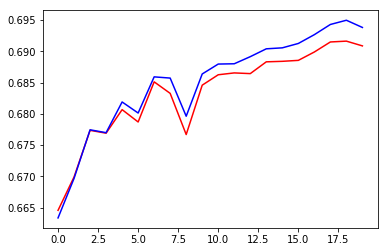

units: [256, 256, 128], dropout: 0.05
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


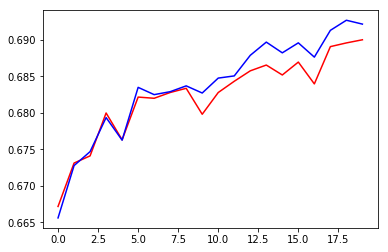

In [45]:
units = [[128,128,128],[256,256,128]]
dropout_rates = [0,0.05]
for u,dropout_rate in zip(units,dropout_rates):
        model = delayNNmodel(input_shape, hidden_units = u, dropout_rate = dropout_rate)
        print("units: {0}, dropout: {1}".format(u,dropout_rate))
        fit_and_plot(model,X_train_balanced,Y_train_balanced,X_test,Y_test,verbose=False,epochs=20)

units: [256, 256, 128], dropout: 0.05
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


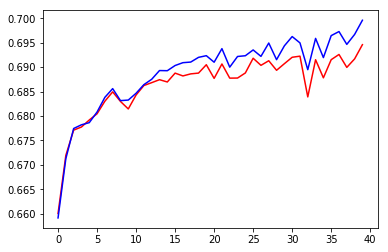

In [47]:
units = [[256,256,128]]
dropout_rates = [0.05]
for u,dropout_rate in zip(units,dropout_rates):
        model = delayNNmodel(input_shape, hidden_units = u, dropout_rate = dropout_rate)
        print("units: {0}, dropout: {1}".format(u,dropout_rate))
        fit_and_plot(model,X_train_balanced,Y_train_balanced,X_test,Y_test,verbose=False,epochs=40)

units: [256, 256, 128], dropout: 0.05
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


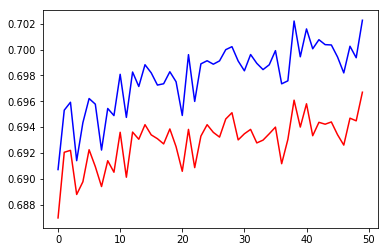

In [17]:
units = [[256,256,128]]
input_shape = [X_train.shape[1]]
dropout_rates = [0.05]
for u,dropout_rate in zip(units,dropout_rates):
        model = delayNNmodel(input_shape, hidden_units = u, dropout_rate = dropout_rate)
        print("units: {0}, dropout: {1}".format(u,dropout_rate))
        fitted_model = fit_and_plot(model,X_train_balanced,Y_train_balanced,X_test,Y_test,verbose=False,epochs=80,
                                    evaluate_offset=30)